In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold,GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
import random
import matplotlib.pyplot as plt
import joblib
import pickle
import lightgbm as lgb
from tqdm import tqdm
import re
from itertools import combinations

In [16]:
import re
from itertools import combinations

def generate_word_pairs(input_string):
    # Split the input string into sentences using a basic regex pattern
    sentences = re.split(r'(?<=[.!?]) +', input_string)
    
    pairs_list = []
    
    for sentence in sentences:
        # Split the sentence into words
        words = sentence.split()
        
        # Generate all possible pairs of words
        word_pairs = list(combinations(words, 2))
        
        # Append the formatted pairs to the list
        formatted_pairs = [f"{pair[0]}{pair[1]}" for pair in word_pairs]
        pairs_list.append((sentence, formatted_pairs))
    
    # Generate the final output string
    output = []
    for sentence, formatted_pairs in pairs_list:
        formatted_pairs_str = ' '.join(formatted_pairs)
        output.append(f"{sentence} {formatted_pairs_str}")
    
    return '\n'.join(output)

input_text = "This is a sample sentence. Here's another one. And one more!"
result = generate_word_pairs(input_text)
print(result)


This is a sample sentence. Thisis Thisa Thissample Thissentence. isa issample issentence. asample asentence. samplesentence.
Here's another one. Here'sanother Here'sone. anotherone.
And one more! Andone Andmore! onemore!


## Some utility functions to print out reports 

In [5]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def print_regression_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print('Mean absolute error:', mean_absolute_error(y_val, y_pred))
    print('Mean squared error:', mean_squared_error(y_val, y_pred))
    print('Root Mean squared error:', np.sqrt(mean_squared_error(y_val, y_pred)))

def print_classification_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')

def print_multilabel_classification_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')



## Data Preview

   rating                                              title  \
0       2                                           Great CD   
1       2  One of the best game music soundtracks - for a...   
2       1                   Batteries died within a year ...   
3       2              works fine, but Maha Energy is better   
4       2                       Great for the non-audiophile   

                                              review  
0  My lovely Pat has one of the GREAT voices of h...  
1  Despite the fact that I have only played a sma...  
2  I bought this charger in Jul 2003 and it worke...  
3  Check out Maha Energy's website. Their Powerex...  
4  Reviewed quite a bit of the combo players and ...  
2    200000
1    200000
Name: rating, dtype: int64


<AxesSubplot:>

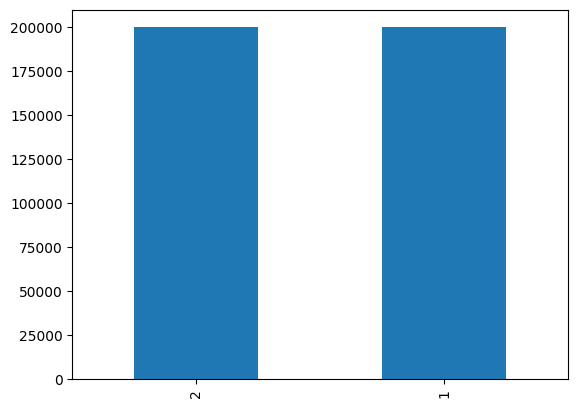

In [9]:
# data set preview
data = pd.read_csv('datasets/amazon/test.csv', encoding='latin-1', header=None)
data.columns = ['rating', 'title', 'review']
print(data.head(5))

print(data['rating'].value_counts())
data['rating'].value_counts().plot(kind='bar')

In [ ]:
label_encoder = LabelEncoder()

def read_data(file_path):
    data = pd.read_csv(file_path, encoding='latin-1', header=None)
    data.columns = ['rating', 'title', 'review']
    data.dropna(inplace=True)
    
    X, y = data['title'].values + data['review'].values, data['rating'].values
    y = label_encoder.fit_transform(y)

    return X, y, data


X, y, data = read_data('datasets/mcdonald_reviews/amazon_test.csv')
print(f'size of data: {len(data)}, shape of X: {X.shape}, shape of y: {y.shape}')

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
fold = 1

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), lowercase=True)
    vectorizer.fit(X_train)

    X_train = vectorizer.transform(X_train)
    X_val = vectorizer.transform(X_val)

    model = XGBClassifier(n_estimators=700, learning_rate=0.2, max_depth=5, colsample_bytree=0.3, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    print_classification_report(y_val, y_pred, fold)
    fold += 1

    misclassified = np.where(y_val != y_pred)
    misclassified_labels = y_val[misclassified]
    misclassified_predictions = y_pred[misclassified]
    misclassified_reviews = data['review'].values[misclassified]

    indices = random.sample(range(len(misclassified_labels)), 10)

    for i in indices:
        print(f'Review: {misclassified_reviews[i]}, Actual: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')

In [9]:
label_encoder = LabelEncoder()

def read_data(file_path, nrows=1):
    data = pd.read_csv(file_path, encoding='latin-1', header=None, nrows=nrows)
    data.columns = ['rating', 'title', 'review']
    data.dropna(inplace=True)
    
    X, y = data['title'].values + data['review'].values, data['rating'].values
    y = label_encoder.fit_transform(y)

    return X, y, data


X, y, data = read_data('datasets/amazon/test.csv', nrows=300000)
print(f'size of data: {len(data)}, shape of X: {X.shape}, shape of y: {y.shape}')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(ngram_range=(1, 10), lowercase=True, max_features=20000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)

model = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=10, colsample_bytree=0.3, n_jobs=-1, random_state=42, subsample=0.1)
#model = RandomForestClassifier(n_estimators=10000, max_depth=100, n_jobs=-1, random_state=42, max_samples=0.8, max_features=0.8)
model.fit(X_train, y_train)

X_val = vectorizer.transform(X_val)
y_pred = model.predict(X_val)

print_classification_report(y_val, y_pred, 1)

misclassified = np.where(y_val != y_pred)
misclassified_labels = y_val[misclassified]
misclassified_predictions = y_pred[misclassified]
misclassified_reviews = data['review'].values[misclassified]

indices = random.sample(range(len(misclassified_labels)), 10)

for i in indices:
    print(f'Review: {misclassified_reviews[i]}, Actual: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')

size of data: 299991, shape of X: (299991,), shape of y: (299991,)


In [4]:
model.save_model('sentiment_analysis_amz_2.model')
joblib.dump(vectorizer, 'vectorizer_amz_2.joblib', compress=True)

['vectorizer_amz_2.joblib']

In [44]:
label_encoder = LabelEncoder()

def read_data(file_path, nrows=1):
    data = pd.read_csv(file_path, encoding='latin-1', header=None, nrows=nrows)
    data.columns = ['rating', 'title', 'review']
    data.dropna(inplace=True)
    
    X, y = data['title'].values + data['review'].values, data['rating'].values
    y = label_encoder.fit_transform(y)

    return X, y, data

sample_size = 20000
X, y, data = read_data('datasets/amazon/test.csv', nrows=sample_size)
# indices = random.sample(range(len(y)), sample_size)
# X, y = X[indices], y[indices]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'shape of X: {X_train.shape}, shape of y: {y_train.shape}')

# for i in tqdm(range(len(X_train)), desc="Processing"):
#     X_train[i] = generate_word_pairs(X_train[i])

print('start training')
stop_words = [
    "the", "and", "to", "of", "it",
    "in", "or", "is", "an", "as",
    "a", "on", "with", "this", "for",
    "but", "at", "by", "from", "not",
    "be", "that", "you", "he", "she",
    "we", "do", "if", "are", "have",
    "will", "so", "all", "my", "there",
    "their", "what", "which", "out", "up",
    "who", "get", "would", "was", "they",
    "your", "his", "her", "can", "has",
    "him", "could", "did", "us", "our"
]



vectorizer = TfidfVectorizer(ngram_range=(1, 5), lowercase=True, max_features=15000, stop_words=stop_words)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)


params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'max_depth': 10,
    'n_estimators': 400,
    'subsample': 0.7,
    'verbose': -1,
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, train_data)

X_val = vectorizer.transform(X_val)
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
y_pred = np.round(y_pred)

print_classification_report(y_val, y_pred, 1)

misclassified = np.where(y_val != y_pred)
misclassified_labels = y_val[misclassified]
misclassified_predictions = y_pred[misclassified]
misclassified_reviews = data['review'].values[misclassified]

indices = random.sample(range(len(misclassified_labels)), 10)

for i in indices:
    print(f'Review: {misclassified_reviews[i]}, Actual: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')

shape of X: (15999,), shape of y: (15999,)
start training


c:\Users\hvutr\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold: 1
Accuracy Score: 0.86125
Confusion Matrix: 
 [[1707  295]
 [ 260 1738]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      2002
           1       0.85      0.87      0.86      1998

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000

Review: edith has created a venue for herself to exorcise melancholic memories with painful melodies. there are no disguises on this collection. lonesome guitars and medicinal piano radiate the mood of broken spirits. she writes all her own songs. these ballads are definite reminders of those unbearable moments we all have to live. they are all gray sky, secluded,isolating tunes. i envision a ironical pace. i thought she was from chicago, millions and millions of people, and she sings stark loneliness, Actual: 0, Predicted: 1.0
Review: the story line is perfect t

In [45]:
model.save_model('sentiment_analysis_amz_2.model')
joblib.dump(vectorizer, 'vectorizer_amz_2.joblib', compress=True)

['vectorizer_amz_2.joblib']